# 1. Data Preprocessing

## 1) 데이터 수 확인

In [2]:
import os

def count_files_in_directory(directory_path):
    return len([f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))])

directory_path = '/content/drive/MyDrive/bitamin_project/new dataset/'

folders = ['foggy', 'rainy', 'snowy', 'sunny', 'sunrise_sunset']

for folder in folders:
  path = directory_path + folder
  print(folder, ':', count_files_in_directory(path))

foggy : 369
rainy : 449
snowy : 395
sunny : 400
sunrise_sunset : 404


In [3]:
import os

def unique_file_formats_in_directory(directory_path):
    file_formats = {os.path.splitext(f)[1].lower() for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))}
    return file_formats

directory_path = '/content/drive/MyDrive/bitamin_project/new dataset/'

folders = ['foggy', 'rainy', 'snowy', 'sunny', 'sunrise_sunset']

for folder in folders:
    path = directory_path + folder
    unique_formats = unique_file_formats_in_directory(path)
    print(folder, ":", unique_formats)

foggy : {'.jpeg', '.jpg', '.png'}
rainy : {'.jpg', '.jpeg'}
snowy : {'.jpg', '.jpeg'}
sunny : {'.jpg', '.jpeg'}
sunrise_sunset : {'.jpg', '.jpeg'}


## 2) import ImageDataGenerator - data augmentation O

In [5]:
import os
import numpy as np
import shutil
from keras.preprocessing.image import ImageDataGenerator

# Defining your directories
base_dir = '/content/drive/MyDrive/bitamin_project/new dataset'
base_dirs = [os.path.join(base_dir, d) for d in os.listdir(base_dir)]

train_dir = '/content/drive/MyDrive/bitamin_project/new data/train'
val_dir = '/content/drive/MyDrive/bitamin_project/new data/val'
test_dir = '/content/drive/MyDrive/bitamin_project/new data/test'

# Ratio of splitting
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Iterate over all directories (classes) in your base directory
for dir_path in base_dirs:
    class_name = os.path.basename(dir_path)

    # Create corresponding directories in train, val, test directories
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Get all file names and shuffle them
    files = os.listdir(dir_path)
    np.random.shuffle(files)

    # Calculate split indices
    train_idx = int(len(files) * train_ratio)
    val_idx = int(len(files) * (train_ratio + val_ratio))

    # Split file names
    train_files = files[:train_idx]
    val_files = files[train_idx:val_idx]
    test_files = files[val_idx:]

    # Move files to corresponding directories
    for file_name in train_files:
        shutil.copy(os.path.join(dir_path, file_name), os.path.join(train_dir, class_name, file_name))

    for file_name in val_files:
        shutil.copy(os.path.join(dir_path, file_name), os.path.join(val_dir, class_name, file_name))

    for file_name in test_files:
        shutil.copy(os.path.join(dir_path, file_name), os.path.join(test_dir, class_name, file_name))

In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = './data/train'
val_dir = './data/val'
test_dir = './data/test'

train_datagen = ImageDataGenerator(width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   fill_mode = 'nearest',
                                   shear_range = 0.2,
                                   rescale = 1/255.0)

test_datagen = ImageDataGenerator(rescale=1./255)

In [132]:
# Load images from directories and apply augmentations
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

Found 1410 images belonging to 5 classes.
Found 302 images belonging to 5 classes.
Found 305 images belonging to 5 classes.


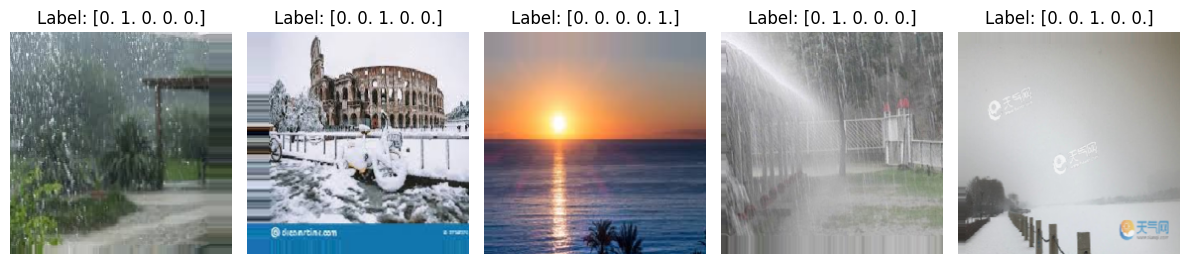

In [133]:
# plot the augmented train images
import matplotlib.pyplot as plt

# Set the number of images to plot
num_images = 5

# Get a batch of augmented images and labels from train_data
augmented_images, augmented_labels = next(train_generator)

# Plot the augmented images
fig, axes = plt.subplots(1, num_images, figsize=(12, 6))

for i in range(num_images):
    image = augmented_images[i]
    label = augmented_labels[i]

    axes[i].imshow(image)
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# 2. Model

In [272]:
import tensorflow as tf
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

xception_model = Xception(weights = 'imagenet',
                          include_top = False,
                          input_shape = (224, 224, 3))

x = Flatten()(xception_model.output)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(5, activation = 'softmax')(x)  # Modify the final Dense layer based on your specific problem

xception = Model(inputs = xception_model.input, outputs = x)

xception.build(input_shape=(None, 224, 224, 3))

83683744/83683744 [==============================] - 54s 1us/step


In [273]:
xception.summary()

Model: "model_28"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_29[0][0]']               
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

 block4_sepconv1_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 28, 28, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 28, 28, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 14, 14, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 14, 14, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 14, 14, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 14, 14, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 14, 14, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 14, 14, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 14, 14, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 14, 14, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (A

In [274]:
from keras.optimizers import Adam

xception.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

rlr_cb = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 10, mode = 'min', verbose = 1)
ely_cb = EarlyStopping(monitor = 'val_loss', patience = 20, mode = 'min', verbose = 1)
checkpoint_cb = ModelCheckpoint(filepath = "./new model/xception_model_2.h5", save_best_only = True,
                                monitor = 'val_loss', mode = 'min', verbose = 1)

history_aug = xception.fit(train_generator, validation_data = validation_generator,
                           epochs = 100, callbacks = [rlr_cb, ely_cb, checkpoint_cb])

Epoch 1/100


2023-08-26 14:05:21.806256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


45/45 [==============================] - ETA: 0s - loss: 1.9889 - accuracy: 0.2206

2023-08-26 14:09:51.536399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 1.60810, saving model to ./new model/xception_model_2.h5
45/45 [==============================] - 300s 6s/step - loss: 1.9889 - accuracy: 0.2206 - val_loss: 1.6081 - val_accuracy: 0.2219 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - ETA: 0s - loss: 1.4622 - accuracy: 0.2589
Epoch 2: val_loss did not improve from 1.60810
45/45 [==============================] - 245s 5s/step - loss: 1.4622 - accuracy: 0.2589 - val_loss: 5.0508 - val_accuracy: 0.2252 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - ETA: 0s - loss: 1.2829 - accuracy: 0.4284
Epoch 3: val_loss did not improve from 1.60810
45/45 [==============================] - 204s 5s/step - loss: 1.2829 - accuracy: 0.4284 - val_loss: 2.9973 - val_accuracy: 0.3278 - lr: 0.0010
Epoch 4/100
45/45 [==============================] - ETA: 0s - loss: 1.1024 - accuracy: 0.5199
Epoch 4: val_loss improved from 1.60810 to 1.28935, saving model to ./new model/xception_model_

# 3. Check Model Performance

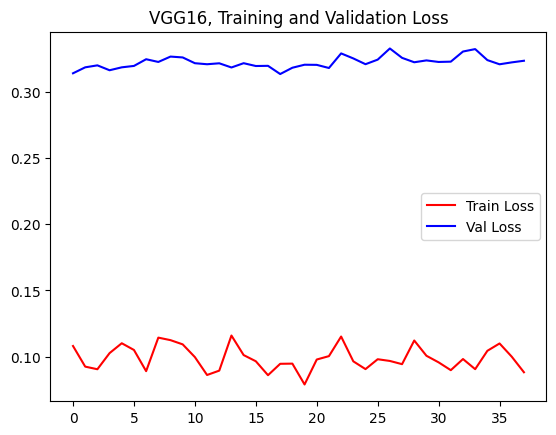

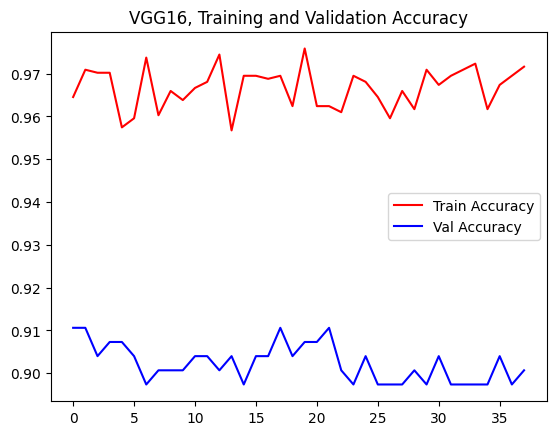

In [262]:
from matplotlib import pyplot as plt

plt.plot(history_aug.history['loss'], 'r', label = 'Train Loss')
plt.plot(history_aug.history['val_loss'], 'b', label = 'Val Loss')
plt.title('VGG16, Training and Validation Loss')
plt.legend()

plt.show()

plt.plot(history_aug.history['accuracy'], 'r', label = 'Train Accuracy')
plt.plot(history_aug.history['val_accuracy'], 'b', label = 'Val Accuracy')
plt.title('VGG16, Training and Validation Accuracy')
plt.legend()

plt.show()

In [263]:
test_loss, test_accuracy = vgg16.evaluate(test_generator)

print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_accuracy)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [264]:
class_indices = test_generator.class_indices
# reversing the dictionary
index_class = {v: k for k, v in class_indices.items()}

In [249]:
index_class

{0: 'foggy', 1: 'rainy', 2: 'snowy', 3: 'sunny', 4: 'sunrise_sunset'}

In [250]:
import numpy as np

y_pred = vgg16.predict(test_generator)
predicted_classes = np.argmax(y_pred, axis=1)

2023-08-26 09:21:43.102145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 8s 645ms/step


In [251]:
true_classes = test_generator.classes

In [252]:
error_indices = np.where(predicted_classes != true_classes)[0]

## test data에 대해 잘못 예측한 경우

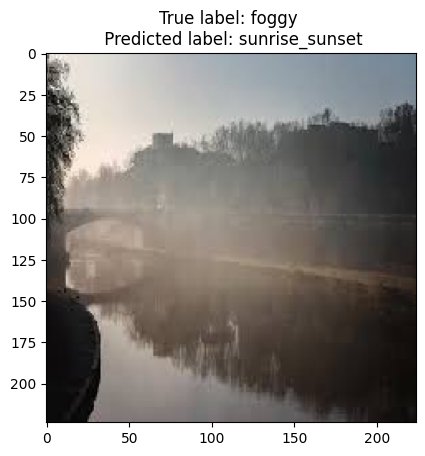

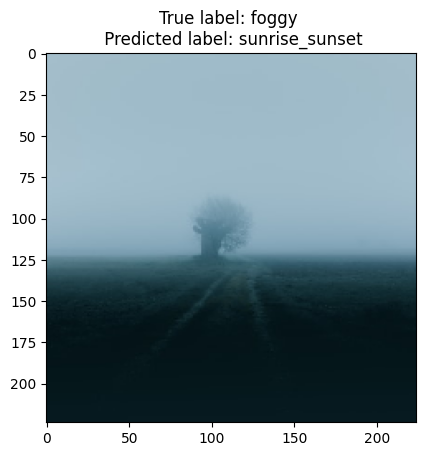

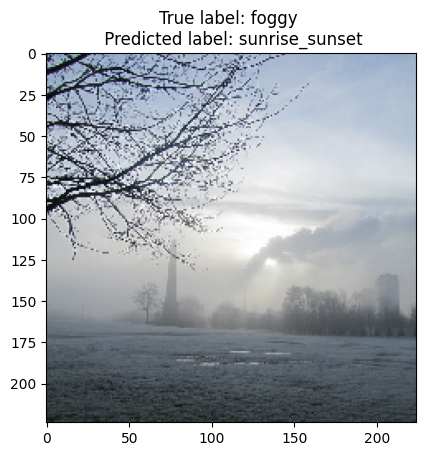

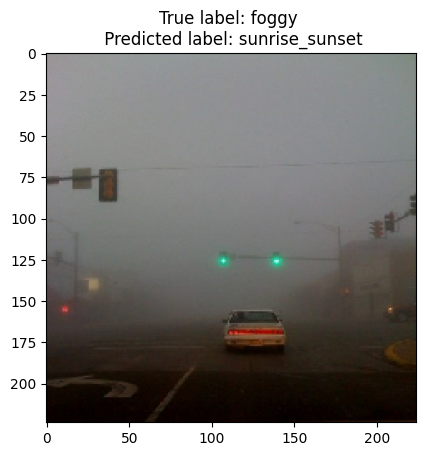

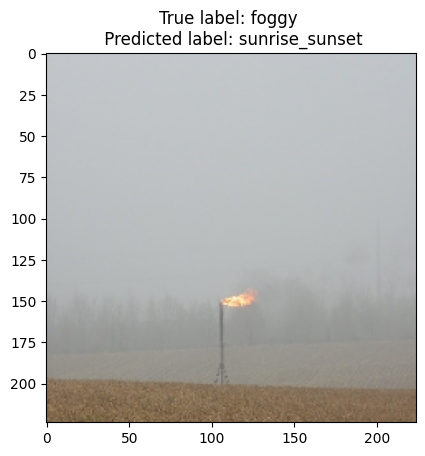

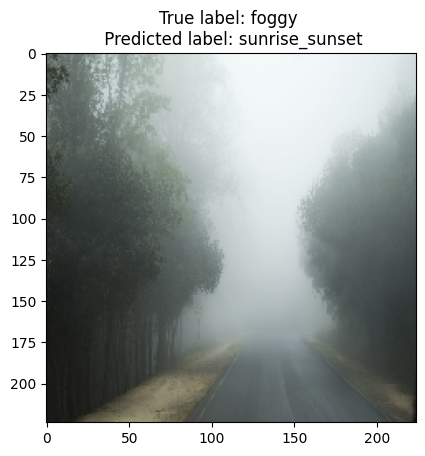

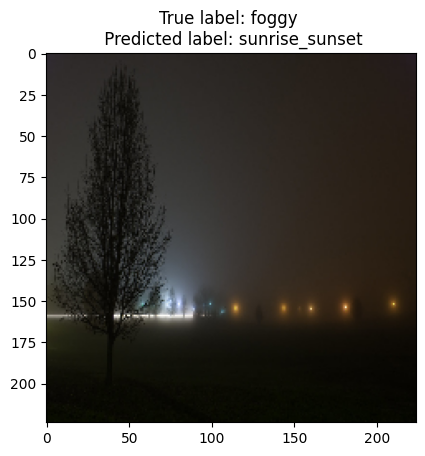

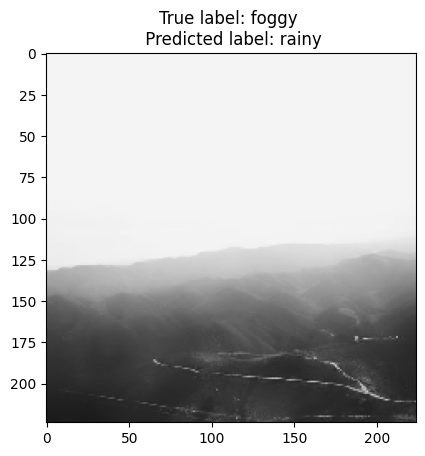

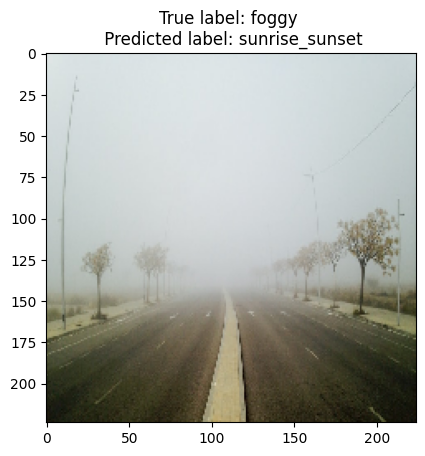

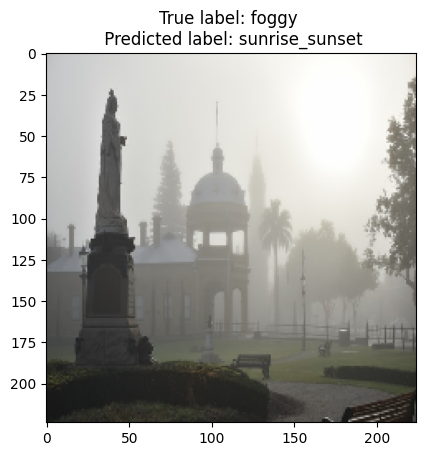

In [253]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# let's say you want to see the first 5 misclassified images
for i in range(10):
    error_index = error_indices[i]

    img_path = test_generator.filepaths[error_index]
    img = image.load_img(img_path, target_size=(224, 224))  # assuming this was your input size

    true_label = index_class[true_classes[error_index]]
    predicted_label = index_class[predicted_classes[error_index]]

    plt.figure()
    plt.imshow(img)
    plt.title(f"True label: {true_label} \n Predicted label: {predicted_label}")
    plt.show()

## Confusion Matrix

In [254]:
class_labels = list(test_generator.class_indices.keys())  # get the labels as a list

In [255]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(true_classes, predicted_classes)

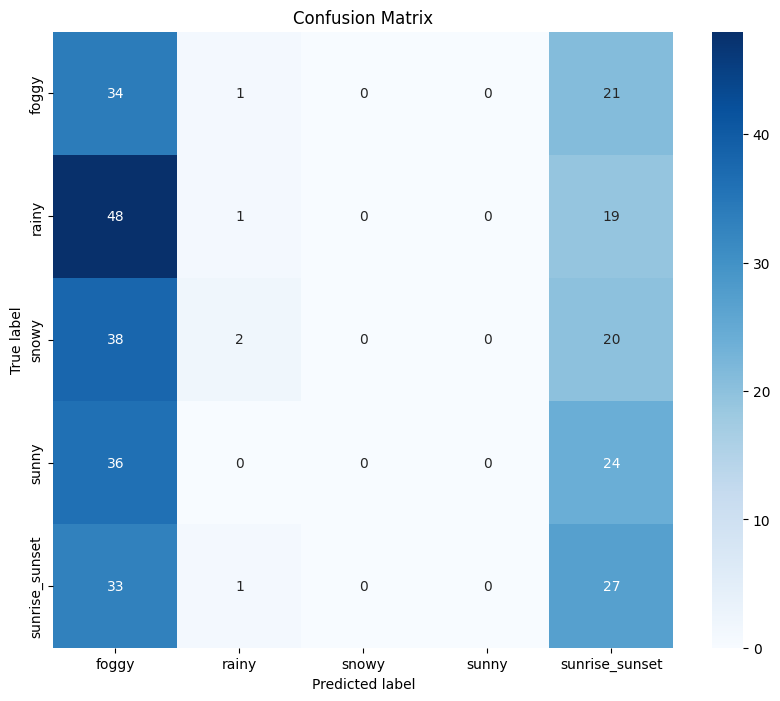

In [256]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

## 내가 갖고있는 이미지 레이블 예측해보기

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np

# Load the image
img_path = '/content/drive/MyDrive/bitamin_project/광화문.jpeg'
img = image.load_img(img_path, target_size=(224, 224))  # assuming this was your input size

# Preprocess the image
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Predict with your model
predictions = resnet50.predict(x)

# Get the class with the highest probability
predicted_class = np.argmax(predictions[0])

# Map the class index to its name
predicted_label = index_class[predicted_class]

1/1 [==============================] - 0s 25ms/step


In [ ]:
predicted_label # 원래 레이블은 sunny가 맞을텐데...

'sunrise_sunset'